In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic

In [2]:
DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
SHORTEST_PATHS = WIKISPEEDIA_PATHS + "shortest-path-distance-matrix.txt"
FEMALES = DATA_FOLDER + "listwomen.txt"
ALL_PATHS = DATA_FOLDER + "all_paths_overview.csv"
PEOPLE_OVERVIEW = DATA_FOLDER + "people_overview.csv"

TEST2020 = WIKISPEEDIA_PATHS + "paths_df_task-B.tsv"

In [3]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt(SHORTEST_PATHS, dtype=str, comments="#", unpack=False)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

all_paths_overview = pd.read_csv(ALL_PATHS).drop(columns = ['Unnamed: 0'])
people_overview = pd.read_csv(PEOPLE_OVERVIEW)

In [4]:
test = pd.read_csv(TEST2020, sep='\t', names=["hashedIpAddress", "source", "target", "finished", "human_path_length", "shortest_path_length", "duration_in_sec"],
                  skiprows=1)
test['path_dev'] = test['human_path_length'] - test['shortest_path_length']
ave_pathdev = test["path_dev"].mean()
min(test["path_dev"])

-5

In [5]:
all_paths_overview
people_target_paths = all_paths_overview.merge(people_overview[['name', 'category', 'gender']], 
                                               how = "inner", left_on = "target", right_on = "name")

#### 1. Distributions

**Success rate**:
Plot the empirical cumulative distribution function (CDF) to visualize the distribution of success_rate.

<AxesSubplot:>

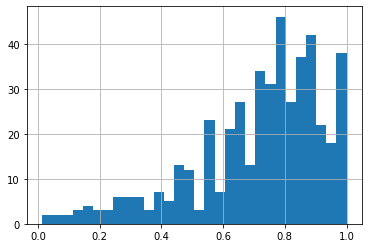

In [6]:
people_overview["succ_rate"].hist(bins = 30)

In [7]:
people_overview["succ_rate"].dropna()
diagnostic.kstest_normal(people_overview["succ_rate"].values, dist = 'norm')

(nan, nan)

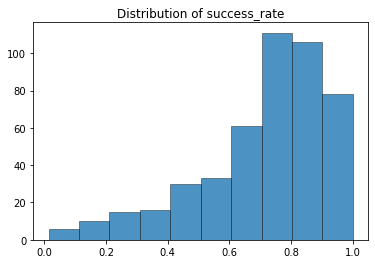

In [8]:
# plot the histogram
plt.hist(people_overview["succ_rate"], 
         color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlabel("")
plt.ylabel("")
plt.title("Distribution of success_rate")
plt.show()

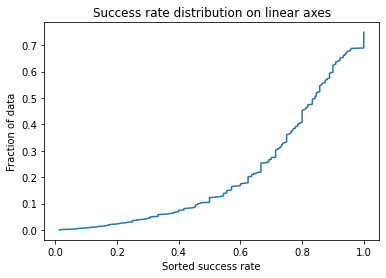

In [9]:
# CDF of success_rate
# CDF(x) = "number of samples <= x"/"number of samples"
x_dist = np.sort(people_overview["succ_rate"])
y_prob = np.arange(len(people_overview["succ_rate"]))/float(len(people_overview["succ_rate"]))

plt.plot(x_dist, y_prob, color = "tab:blue")
plt.xlabel("Sorted success rate")
plt.ylabel("Fraction of data")
plt.title("Success rate distribution on linear axes")
plt.show()

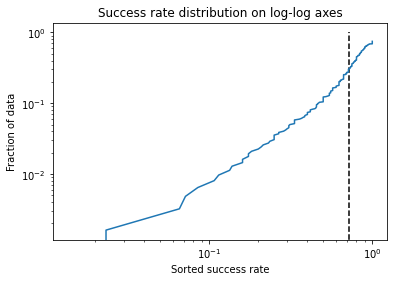

In [10]:
arith_mean = people_overview["succ_rate"].mean()

plt.loglog(x_dist, y_prob, color = "tab:blue")
plt.vlines(arith_mean, ymin= 0, ymax = 1, linestyles="--", colors="black", label=f"arithmetic mean: {arith_mean:.2f}" )
plt.xlabel("Sorted success rate")
plt.ylabel("Fraction of data")
plt.title("Success rate distribution on log-log axes")
plt.show()

**Playtime duration**: 
Let's find the average playtime duration for every path (`durationInSec`).

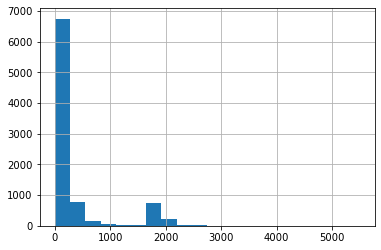

In [11]:
people_target_paths["durationInSec"].hist(bins = 20)
plt.show()

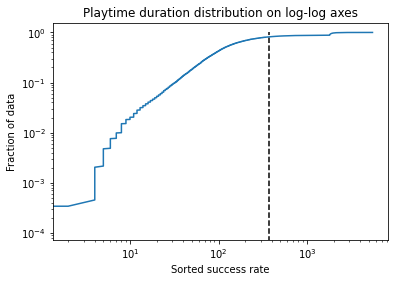

In [12]:
# CDF of playtime_duration
# CDF(x) = "number of samples <= x"/"number of samples"
x_dist = np.sort(people_target_paths["durationInSec"])
y_prob = np.arange(len(people_target_paths["durationInSec"]))/float(len(people_target_paths["durationInSec"]))
ave_playtime = people_target_paths["durationInSec"].mean()

plt.loglog(x_dist, y_prob, color = "tab:blue")
plt.vlines(ave_playtime, ymin= 0, ymax = 1, linestyles="--", colors="black", label=f"arithmetic mean: {arith_mean:.2f}" )
plt.xlabel("Sorted success rate")
plt.ylabel("Fraction of data")
plt.title("Playtime duration distribution on log-log axes")
plt.show()

**Path deviation**:
We add a column `path_dev` that displays the difference between `human_path_length` and `shortest_path_length`.
We find the average value of path_dev and plot a histogram to show the distribution of path_deviation.

In [13]:
people_target_paths['path_dev'] = people_target_paths['human_path_length'] - people_target_paths['shortest_path_length']

a = min(people_target_paths["path_dev"]) # we note that the minimum path deviation is negative
# PRE-PROCESSING: filter all rows that have a negative path_dev: not possible
people_target_paths = people_target_paths.drop(people_target_paths.index[people_target_paths['path_dev'] < 0])

In [14]:
ave_pathdev = people_target_paths["path_dev"].mean()
path_dev_count = people_target_paths["path_dev"].value_counts()

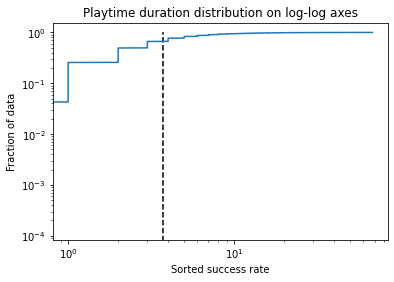

In [15]:
# CDF of success_rate
# CDF(x) = "number of samples <= x"/"number of samples"
x_dist = np.sort(people_target_paths["path_dev"])
y_prob = np.arange(len(people_target_paths["path_dev"]))/float(len(people_target_paths["path_dev"]))

plt.loglog(x_dist, y_prob, color = "tab:blue")
plt.vlines(ave_pathdev, ymin= 0, ymax = 1, linestyles="--", colors="black", label=f"arithmetic mean: {arith_mean:.2f}" )
plt.xlabel("Sorted success rate")
plt.ylabel("Fraction of data")
plt.title("Playtime duration distribution on log-log axes")
plt.show()

**Number of back click**

In [16]:
ave_backclicks = people_target_paths["backclicks"].mean()

In [17]:
ave_backclicks

0.4588873112172454

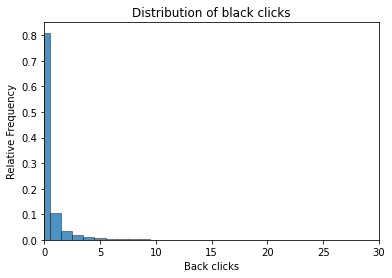

In [18]:
# define parameters for the histogram 
max_year = max(people_target_paths["backclicks"])
min_year = min(people_target_paths["backclicks"])
bin_size = 1 # to represent every year, we use binsize = 1
# the -0.5 centers the bins, and since the years are ints and not floats it won't change the results of the histogram
bin_edges = np.arange(min_year, max_year + 1, 1) - 0.5 

# plot the histogram
plt.hist(people_target_paths["backclicks"], density = True, bins = bin_edges, align = "mid",
         color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlim([0, max_year +1])
#plt.ylim([0,0.05])
plt.xlabel("Back clicks")
plt.ylabel("Relative Frequency")
plt.title("Distribution of black clicks")
plt.show()

**Difficulty rating**

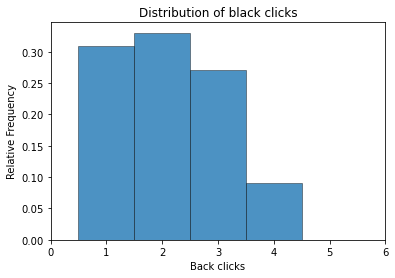

In [19]:
ave_rating = people_target_paths["rating"].mean()

path_rating = people_target_paths.dropna(subset = ["rating"])

# define parameters for the histogram 
max_year = max(path_rating["rating"])
min_year = min(path_rating["rating"])
bin_size = 1 # to represent every year, we use binsize = 1
# the -0.5 centers the bins, and since the years are ints and not floats it won't change the results of the histogram
bin_edges = np.arange(min_year, max_year + 1, 1) - 0.5 

# plot the histogram
plt.hist(people_target_paths["rating"], density = True, bins = bin_edges, align = "mid",
         color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlim([0, max_year +1])
#plt.ylim([0,0.05])
plt.xlabel("Back clicks")
plt.ylabel("Relative Frequency")
plt.title("Distribution of black clicks")
plt.show()

In [20]:
rate_perc = len(path_rating)/len(people_target_paths)
print("Fraction of players that rate: {:.2%}".format(rate_perc))

Fraction of players that rate: 44.35%


#### 2. Linear regression

In [21]:
lr_succ_rate = people_overview[["gender", "succ_rate"]]
lr_succ_rate

,gender,succ_rate
0,male,0.777778
1,male,0.945946
2,male,0.818182
3,male,0.865136
4,male,0.730769
...,...,...
616,male,NaN
617,male,0.714286
618,male,0.333333
619,male,0.833333


In [22]:
lr_succ_rate.loc[lr_succ_rate['gender'] == 'male', 'gender01'] = 0 
lr_succ_rate.loc[lr_succ_rate['gender'] == 'female', 'gender01'] = 1
lr_succ_rate = lr_succ_rate.dropna(subset = ['succ_rate'], axis = 'index')
lr_succ_rate['log_succ_rate'] = np.log(lr_succ_rate['succ_rate'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-22-96659ad35c70>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [54]:
np.random.seed(2)

# declare the model
mod = smf.ols(formula='succ_rate ~ gender01', data=lr_succ_rate)

# fit the model
res = mod.fit()

# print the summary output 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              succ_rate   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     18.57
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           2.00e-05
Time:                        17:57:53   Log-Likelihood:                 69.137
No. Observations:                 466   AIC:                            -134.3
Df Residuals:                     464   BIC:                            -126.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7322      0.010     72.623      0.0

In [51]:
np.random.seed(2)

# declare the model
mod = smf.logit(formula='gender01 ~ succ_rate', data=lr_succ_rate)

# fit the model
res = mod.fit()

# print the summary output 
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.255455
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               gender01   No. Observations:                  466
Model:                          Logit   Df Residuals:                      464
Method:                           MLE   Df Model:                            1
Date:                Wed, 14 Dec 2022   Pseudo R-squ.:                 0.06086
Time:                        17:57:20   Log-Likelihood:                -119.04
converged:                       True   LL-Null:                       -126.76
Covariance Type:            nonrobust   LLR p-value:                 8.570e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6117      0.456     -1.343      0.179      -1.505       0.281
succ_rate     -2.8289      0.

The model summarises the average difference in success rate between target articles that end with women and men articles.

In [55]:
# we extract the coefficients from the model
coefficients = res.params.values
beta0 = coefficients[0]     # intercept
beta1 = coefficients[1]     # coeff for ind

y_est_man = beta0 
y_est_woman = beta0 + beta1

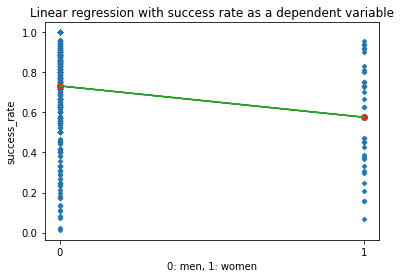

In [56]:
plt.scatter(lr_succ_rate['gender01'], lr_succ_rate['succ_rate'], marker = "D", s = 10)
plt.plot(lr_succ_rate['gender01'], beta0+beta1*lr_succ_rate['gender01'], color = "tab:green")
plt.scatter(0, y_est_man, color = "tab:red")
plt.scatter(1, y_est_woman, color = "tab:red")
plt.title('Linear regression with success rate as a dependent variable') 
plt.ylabel('success_rate') 
plt.xlabel('0: men, 1: women')
plt.xticks([0, 1])
plt.show()

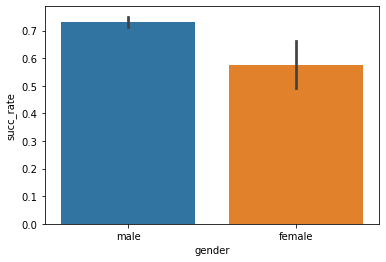

In [26]:
ax = sns.barplot(x="gender", y="succ_rate", data=people_overview.loc[people_overview['gender'].isin(['male','female'])])

The difference is significant between the two groups since the 95% confidence intervals are not overlapping.

##### Playtime duration

In [27]:
lr_playtime_dur = people_target_paths[["durationInSec", "gender", "finished"]]

In [28]:
lr_playtime_dur = lr_playtime_dur.replace(["male", "female"], [0,1])
lr_playtime_dur = lr_playtime_dur.replace([True, False], [1,0])

In [29]:
lr_playtime_dur

,durationInSec,gender,finished
0,175,0,1
1,110,0,1
2,160,0,1
3,74,0,1
4,125,0,1
...,...,...,...
8822,163,0,0
8824,154,0,0
8825,127,0,0
8827,319,0,0


In [30]:
np.random.seed(2)

# declare the model
mod = smf.ols(formula='durationInSec ~ gender + finished', data=lr_playtime_dur)

# fit the model
res = mod.fit()

# print the summary output 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          durationInSec   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     1766.
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:56:41   Log-Likelihood:                -58470.
No. Observations:                7747   AIC:                         1.169e+05
Df Residuals:                    7744   BIC:                         1.170e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    904.7982     11.510     78.609      0.0

In [31]:
# we extract the coefficients from the model
coefficients = res.params.values
beta0 = coefficients[0]     # intercept
beta1 = coefficients[1]     # coeff for gender
beta2 = coefficients[2]     # coeff for finished

#y_est_man = beta0 
#y_est_woman = beta0 + beta1

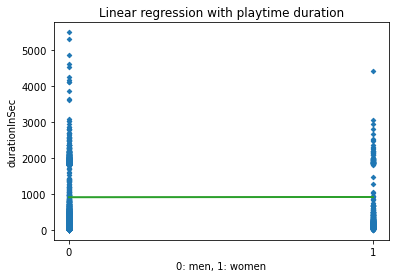

In [32]:
plt.scatter(lr_playtime_dur['gender'], lr_playtime_dur['durationInSec'], marker = "D", s = 10)
plt.plot(lr_playtime_dur['gender'], beta0+beta1*lr_playtime_dur['gender'], color = "tab:green")
#plt.scatter(0, y_est_man, color = "tab:red")
#plt.scatter(1, y_est_woman, color = "tab:red")
plt.title('Linear regression with playtime duration') 
plt.ylabel('durationInSec') 
plt.xlabel('0: men, 1: women')
plt.xticks([0, 1])
plt.show()

##### Path deviation

In [33]:
lr_path_dev = people_target_paths[["path_dev", "gender", "finished"]]

In [34]:
lr_path_dev

,path_dev,gender,finished
0,4,male,True
1,3,male,True
2,3,male,True
3,2,male,True
4,2,male,True
...,...,...,...
8822,7,male,False
8824,9,male,False
8825,2,male,False
8827,0,male,False


In [35]:
lr_path_dev = lr_path_dev.replace(["male", "female"], [0,1])
lr_path_dev = lr_path_dev.replace([True, False], [1,0])

In [36]:
np.random.seed(2)

# declare the model
mod = smf.ols(formula='path_dev ~ gender + finished', data=lr_path_dev)

# fit the model
res = mod.fit()

# print the summary output 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               path_dev   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     19.13
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           5.16e-09
Time:                        17:56:41   Log-Likelihood:                -22409.
No. Observations:                7747   AIC:                         4.482e+04
Df Residuals:                    7744   BIC:                         4.485e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9841      0.110     36.375      0.0

In [37]:
coefficients = res.params.values
beta0 = coefficients[0]     # intercept
beta1 = coefficients[1]     # coeff for gender
beta2 = coefficients[2]     # coeff for finished

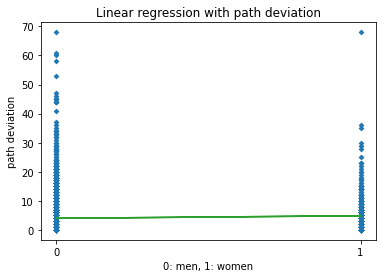

In [38]:
plt.scatter(lr_path_dev['gender'], lr_path_dev['path_dev'], marker = "D", s = 10)
plt.plot(lr_path_dev['gender'], beta0+beta1*lr_path_dev['gender'], color = "tab:green")
#plt.scatter(0, y_est_man, color = "tab:red")
#plt.scatter(1, y_est_woman, color = "tab:red")
plt.title('Linear regression with path deviation') 
plt.ylabel('path deviation') 
plt.xlabel('0: men, 1: women')
plt.xticks([0, 1])
plt.show()

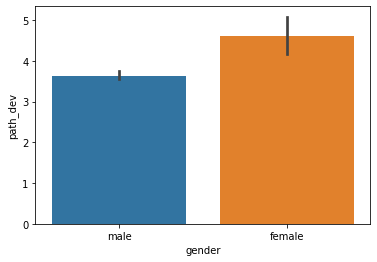

In [39]:
ax = sns.barplot(x="gender", y="path_dev", data=people_target_paths.loc[people_target_paths['gender'].isin(['male','female'])])

##### Number of back clicks

In [40]:
lr_back_clicks = people_target_paths[["backclicks", "gender", "finished"]]
lr_back_clicks = lr_back_clicks.replace(["male", "female"], [0,1])
lr_back_clicks = lr_back_clicks.replace([True, False], [1,0])

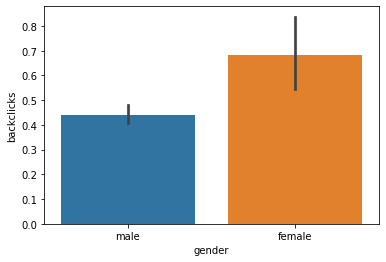

In [41]:
ax = sns.barplot(x="gender", y="backclicks", data=people_target_paths.loc[people_target_paths['gender'].isin(['male','female'])])

In [42]:
np.random.seed(2)

# declare the model
mod = smf.ols(formula='backclicks ~ gender + finished', data=lr_back_clicks)

# fit the model
res = mod.fit()

# print the summary output 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             backclicks   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     56.95
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           2.81e-25
Time:                        17:56:42   Log-Likelihood:                -14421.
No. Observations:                7747   AIC:                         2.885e+04
Df Residuals:                    7744   BIC:                         2.887e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7883      0.039     20.182      0.0

In [43]:
coefficients = res.params.values
beta0 = coefficients[0]     # intercept
beta1 = coefficients[1]     # coeff for gender
beta2 = coefficients[2]     # coeff for finished

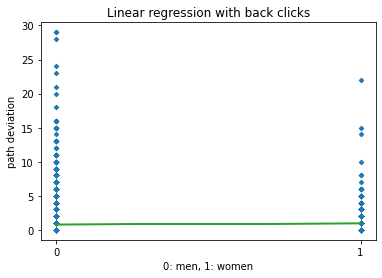

In [44]:
plt.scatter(lr_back_clicks['gender'], lr_back_clicks['backclicks'], marker = "D", s = 10)
plt.plot(lr_back_clicks['gender'], beta0+beta1*lr_back_clicks['gender'], color = "tab:green")
#plt.scatter(0, y_est_man, color = "tab:red")
#plt.scatter(1, y_est_woman, color = "tab:red")
plt.title('Linear regression with back clicks') 
plt.ylabel('path deviation') 
plt.xlabel('0: men, 1: women')
plt.xticks([0, 1])
plt.show()

##### Difficulty rating

In [45]:
lr_rating = people_target_paths[["rating", "gender", "finished"]]
lr_rating = lr_rating.replace(["male", "female"], [0,1])
lr_rating = lr_rating.replace([True, False], [1,0])

In [46]:
lr_rating = lr_rating.dropna(subset = ["rating"])

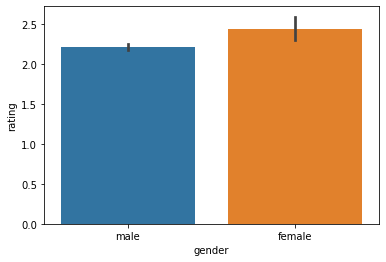

In [47]:
ax = sns.barplot(x="gender", y="rating", data=people_target_paths.loc[people_target_paths['gender'].isin(['male','female'])])

In [48]:
np.random.seed(2)

# declare the model
mod = smf.ols(formula='rating ~ gender + finished', data=lr_rating)

# fit the model
res = mod.fit()

# print the summary output 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.575
Date:                Wed, 14 Dec 2022   Prob (F-statistic):            0.00343
Time:                        17:56:42   Log-Likelihood:                -5097.9
No. Observations:                3436   AIC:                         1.020e+04
Df Residuals:                    3434   BIC:                         1.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1094      0.009    118.182      0.0

In [49]:
coefficients = res.params.values
beta0 = coefficients[0]     # intercept
beta1 = coefficients[1]     # coeff for gender
beta2 = coefficients[2]     # coeff for finished

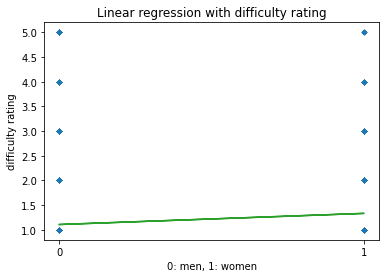

In [50]:
plt.scatter(lr_rating['gender'], lr_rating['rating'], marker = "D", s = 10)
plt.plot(lr_rating['gender'], beta0+beta1*lr_rating['gender'], color = "tab:green")
#plt.scatter(0, y_est_man, color = "tab:red")
#plt.scatter(1, y_est_woman, color = "tab:red")
plt.title('Linear regression with difficulty rating') 
plt.ylabel('difficulty rating') 
plt.xlabel('0: men, 1: women')
plt.xticks([0, 1])
plt.show()